In [1]:
!pip install nvidia-cutlass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 38.0 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Tue Jan 21 01:14:41 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
import sys

import cutlass
import torch
import triton
import triton.language as tl

In [4]:
@triton.jit
def base_kernel(
    a_ptr,
    b_ptr,
    c_ptr,
    M,
    N,
    K,
    stride_am,
    stride_ak,
    stride_bk,
    stride_bn,
    stride_cm,
    stride_cn,
    GROUP_SIZE_M: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
    """
    Triton tutorial implementation of the kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def matmul(a, b, kernel, GROUP_SIZE_M):
    """
    Perform matrix multiplication using the provided matmul kernel.

    This is identical to the tutorial implementation, except that we allow for the option of passing in kernel
    parameters directly for later plotting (passing in GROUP_SIZE_M) purposes.
    """
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    M, K = a.shape
    K, N = b.shape
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),)
    kernel[grid](
        a,
        b,
        c,
        M,
        N,
        K,
        a.stride(0),
        a.stride(1),
        b.stride(0),
        b.stride(1),
        c.stride(0),
        c.stride(1),
        GROUP_SIZE_M=GROUP_SIZE_M,
    )

    return c

In [5]:
def run_benchmarks(block_size_lst, gsm_lst, num_stages_lst, num_warps_lst) -> None:
    """
    Plot the performance of the matmul kernel autotuned at every different (GROUP_SIZE_M, K).
    """
    configs = []
    for bsm in block_size_lst:
        for bsn in block_size_lst:
            for bsk in block_size_lst:
                for ns in num_stages_lst:
                    for nw in num_warps_lst:
                        configs.append(
                            triton.Config(
                                {
                                    "BLOCK_SIZE_M": bsm,
                                    "BLOCK_SIZE_N": bsn,
                                    "BLOCK_SIZE_K": bsk,
                                },
                                num_stages=ns,
                                num_warps=nw,
                            )
                        )

    tunable_kernel = triton.autotune(configs=configs, key=["K", "GROUP_SIZE_M"])(base_kernel)

    benches = [
        triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[i for i in range(1024, 8193, 1024)],
            line_arg="provider",
            line_vals=["triton", "cublas", "cutlass"],
            line_names=["Triton", "cuBLAS", "cuTLASS"],
            styles=[("red", "-"), ("green", "-"), ("blue", "-")],
            ylabel="Time (ms)",
            plot_name=f"gsm{gsm}_per-k-triton-autotuned_matmul_row-major_fp16",
            args={
                "M": 8192,
                "N": 8192,
                "gsm": gsm,
            },
        )
        for gsm in gsm_lst
    ]

    @triton.testing.perf_report(benches)
    def benchmark(M, N, K, gsm, provider):
        a = torch.randn((M, K), device="cuda", dtype=torch.float16)
        b = torch.randn((K, N), device="cuda", dtype=torch.float16)

        plan = cutlass.op.Gemm(element=torch.float16, layout=cutlass.LayoutType.RowMajor)
        c = torch.empty((M, N), device="cuda", dtype=torch.float16)
        d = torch.empty((M, N), device="cuda", dtype=torch.float16)

        if provider == "triton":
            mean_ms = triton.testing.do_bench(lambda: matmul(a, b, tunable_kernel, gsm))
        elif provider == "cublas":
            mean_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
        elif provider == "cutlass":
            mean_ms = triton.testing.do_bench(lambda: plan.run(a, b, c, d))

        return mean_ms

    benchmark.run(print_data=True, show_plots=True, save_path="./per-k-gsm-triton-autotuned_matmul_perf")

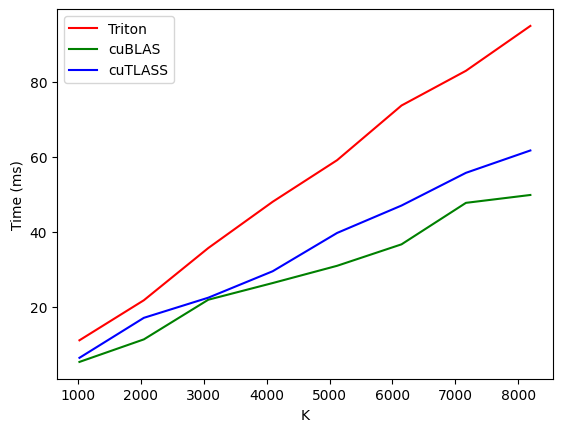

<Figure size 640x480 with 0 Axes>

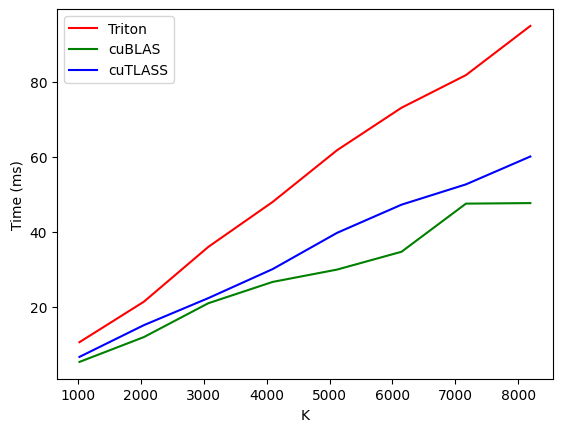

<Figure size 640x480 with 0 Axes>

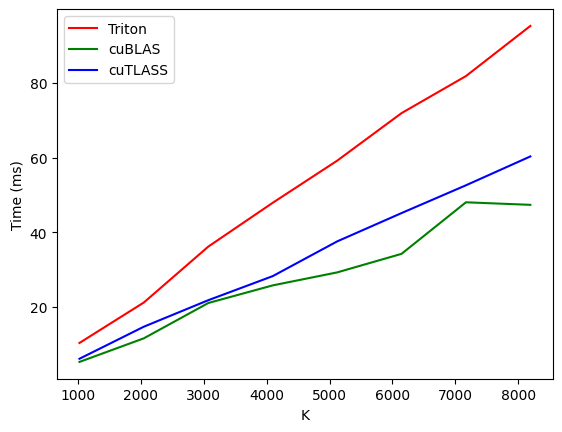

<Figure size 640x480 with 0 Axes>

In [10]:
os.environ["TRITON_PRINT_AUTOTUNING"] = "1"
os.environ["MLIR_ENABLE_DUMP"] = "1"
os.environ["TRITON_ALWAYS_COMPILE"] = "1"
os.environ["LLVM_IR_ENABLE_DUMP"] = "1"

# Lists of values for each parameter to grid tune over
block_size_lst = [64]
num_stages_lst = [2]
num_warps_lst = [16, 32]
gsm_list = [4, 8, 10]

stdout = sys.stdout
try:
  with open("autotuning_output", "w") as sys.stdout:
      run_benchmarks(block_size_lst, gsm_list, num_stages_lst, num_warps_lst)
finally:
  sys.stdout = stdout # reset stdout

In [11]:
!zip -r /content/per-k-gsm-triton-autotuned_matmul_perf.zip /content/per-k-gsm-triton-autotuned_matmul_perf/

  adding: content/per-k-gsm-triton-autotuned_matmul_perf/ (stored 0%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/gsm8_per-k-triton-autotuned_matmul_row-major_fp16.csv (deflated 44%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/gsm8_per-k-triton-autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/gsm10_per-k-triton-autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/gsm10_per-k-triton-autotuned_matmul_row-major_fp16.csv (deflated 44%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/gsm4_per-k-triton-autotuned_matmul_row-major_fp16.csv (deflated 44%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/results.html (deflated 58%)
  adding: content/per-k-gsm-triton-autotuned_matmul_perf/gsm4_per-k-triton-autotuned_matmul_row-major_fp16.png (deflated 90%)


In [12]:
from google.colab import files
files.download("/content/per-k-gsm-triton-autotuned_matmul_perf.zip")
files.download("/content/autotuning_output.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>